In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [12]:
# Définition du Dataset pour le langage des signes
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file):
        # Chargement des données à partir d'un fichier CSV
        self.data = pd.read_csv(csv_file)
        # Les étiquettes sont la première colonne
        self.labels = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        # Les images sont les colonnes restantes, normalisées entre 0 et 1
        self.images = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 28, 28) / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


In [13]:
# Définition du modèle RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Définition de la couche RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Couche de sortie entièrement connectée
        self.fc = nn.Linear(hidden_size * 28, num_classes)

    def forward(self, x):
        # Initialisation de l'état caché
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Passage à travers la couche RNN
        out, _ = self.rnn(x, h0)
        # Redimensionnement pour la couche entièrement connectée
        out = out.reshape(out.size(0), -1)
        # Passage par la couche entièrement connectée
        out = self.fc(out)
        return out


In [14]:
# Chargement des datasets d'entraînement et de test
train_dataset = SignLanguageDataset('../../data/sign_mnist_train.csv')
test_dataset = SignLanguageDataset('../../data/sign_mnist_test.csv')

# Définition des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Vérification de la disponibilité de CUDA pour le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paramètres du modèle
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 26
num_epochs = 10
learning_rate = 0.001

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = RNNModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Listes pour stocker les précisions d'entraînement et de test
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Définir le dispositif pour l'entraînement : utiliser le GPU si disponible, sinon le CPU
# Cette ligne vérifie si CUDA (GPU) est disponible sur le système. Si oui, le modèle et les données seront déplacés vers le GPU pour un entraînement plus rapide. Sinon, ils resteront sur le CPU.

# Paramètres du modèle CNN
# Initialisation du modèle CNN et déplacement sur le dispositif (GPU ou CPU)

# Définition de la fonction de perte
# La fonction de perte choisie est la cross-entropy (entropie croisée), qui est couramment utilisée pour les problèmes de classification multi-classes. 
# La formule de la perte de cross-entropy est :
# Loss = -sum(y_true * log(y_pred)), 
# où y_true est le vecteur des véritables étiquettes (one-hot encoded) et y_pred est le vecteur des probabilités prédites.

# Définition de l'optimiseur
# L'optimiseur choisi est Adam (Adaptive Moment Estimation), qui est une méthode d'optimisation stochastique efficace couramment utilisée pour l'entraînement des réseaux de neurones.
# Adam combine les avantages de deux autres extensions de descente de gradient stochastique : AdaGrad et RMSProp.
# La formule d'Adam est :
# m_t = beta1 * m_(t-1) + (1 - beta1) * g_t
# v_t = beta2 * v_(t-1) + (1 - beta2) * g_t^2
# m_t_hat = m_t / (1 - beta1^t)
# v_t_hat = v_t / (1 - beta2^t)
# theta_t = theta_(t-1) - lr * m_t_hat / (sqrt(v_t_hat) + epsilon)
# où m_t et v_t sont les moyennes mobiles des gradients et de leurs carrés, beta1 et beta2 sont les coefficients de moyenne mobile, g_t est le gradient à l'étape t, lr est le taux d'apprentissage, et epsilon est un petit nombre pour éviter la division par zéro.

# Le taux d'apprentissage (learning rate) est défini à 0.001, un choix courant qui fonctionne bien dans de nombreux scénarios.


In [15]:
# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Passage avant
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Rétropropagation et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calcul de la précision sur le jeu d'entraînement
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(loss.item())
    
    # Calcul de la précision sur le jeu de test
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    test_losses.append(loss.item())
    
    # Affichage de l'évolution des performances
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/10], Loss: 0.3983, Train Accuracy: 83.17%, Test Accuracy: 70.45%
Epoch [2/10], Loss: 0.0661, Train Accuracy: 96.55%, Test Accuracy: 79.85%
Epoch [3/10], Loss: 0.0232, Train Accuracy: 99.80%, Test Accuracy: 81.89%
Epoch [4/10], Loss: 0.0026, Train Accuracy: 100.00%, Test Accuracy: 84.17%
Epoch [5/10], Loss: 0.0021, Train Accuracy: 100.00%, Test Accuracy: 84.86%
Epoch [6/10], Loss: 0.0008, Train Accuracy: 100.00%, Test Accuracy: 84.66%
Epoch [7/10], Loss: 0.0008, Train Accuracy: 100.00%, Test Accuracy: 84.91%
Epoch [8/10], Loss: 0.0007, Train Accuracy: 100.00%, Test Accuracy: 85.22%
Epoch [9/10], Loss: 0.0005, Train Accuracy: 100.00%, Test Accuracy: 85.39%
Epoch [10/10], Loss: 0.0004, Train Accuracy: 100.00%, Test Accuracy: 85.15%


In [16]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

save_model(model, 'rnn_final.pth')

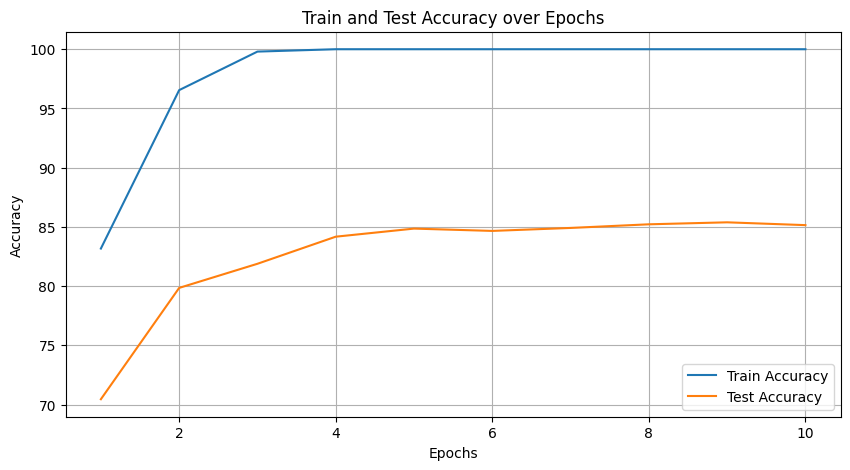

In [17]:
# Visualisation des courbes de précision
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


In [18]:
# Évaluation finale et matrice de confusion
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')
    

Accuracy of the model on the test images: 85.15%


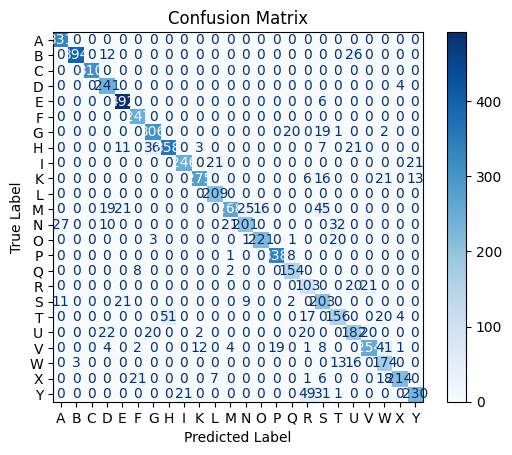

In [19]:
# Génération et affichage de la matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Définition des lettres représentant chaque classe
class_labels = list("ABCDEFGHIKLMNOPQRSTUVWXY")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Réutilisation de la classe SignLanguageDataset
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.labels = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.images = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [21]:
# Définition du modèle CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Première couche de convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Pourquoi : 
        # La couche de convolution applique 32 filtres (ou kernels) de taille 3x3 à l'image d'entrée. 
        # Le padding de 1 assure que la dimension spatiale de la sortie est la même que celle de l'entrée.
        # Cela permet d'extraire des caractéristiques locales de l'image, comme les contours et les textures.

        # Deuxième couche de convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Pourquoi : 
        # Cette couche applique 64 filtres de taille 3x3 aux sorties de la première couche de convolution.
        # Elle permet d'extraire des caractéristiques plus complexes en combinant les caractéristiques détectées par la première couche.

        # Couche de pooling (sous-échantillonnage)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pourquoi : 
        # La couche de pooling réduit la dimension spatiale de l'image de moitié (2x2) en prenant le maximum dans chaque région.
        # Cela permet de réduire le nombre de paramètres et de calculs dans le réseau, et aide à rendre les représentations des caractéristiques invariantes aux petites translations.

        # Première couche entièrement connectée
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Pourquoi : 
        # Cette couche prend les caractéristiques aplaties (flattened) des couches de convolution précédentes et les projette dans un espace de 128 dimensions.
        # Elle permet d'apprendre des combinaisons complexes de caractéristiques pour la classification.

        # Deuxième couche entièrement connectée (couche de sortie)
        self.fc2 = nn.Linear(128, 26)
        # Pourquoi : 
        # La couche de sortie projette les 128 dimensions dans l'espace des 26 classes (lettres de l'alphabet, à l'exception de J et Z).
        # Cette couche est responsable de la classification finale en attribuant une probabilité à chaque classe.

        # Fonction d'activation ReLU
        self.relu = nn.ReLU()
        # Pourquoi : 
        # La fonction d'activation ReLU (Rectified Linear Unit) introduit de la non-linéarité dans le modèle.
        # Elle permet de capturer des relations complexes dans les données et aide à éviter le problème de gradient vanishing.

        # Couche de Dropout
        self.dropout = nn.Dropout(0.5)
        # Pourquoi : 
        # Le Dropout est une technique de régularisation qui désactive aléatoirement une fraction des neurones pendant l'entraînement (ici 50%).
        # Cela aide à prévenir le surapprentissage (overfitting) en forçant le réseau à apprendre des représentations plus robustes.

    def forward(self, x):
        # Propagation avant à travers la première couche de convolution suivie de ReLU et de MaxPooling
        x = self.pool(self.relu(self.conv1(x)))
        
        # Propagation avant à travers la deuxième couche de convolution suivie de ReLU et de MaxPooling
        x = self.pool(self.relu(self.conv2(x)))
        
        # Aplatir les sorties des couches de convolution en un vecteur 1D
        x = x.view(-1, 64 * 7 * 7)
        
        # Propagation avant à travers la première couche entièrement connectée suivie de ReLU
        x = self.relu(self.fc1(x))
        
        # Appliquer Dropout pendant l'entraînement
        x = self.dropout(x)
        
        # Propagation avant à travers la couche de sortie entièrement connectée
        x = self.fc2(x)
        
        return x

In [22]:
# Chargement des datasets
train_dataset = SignLanguageDataset('../../data/sign_mnist_train.csv')
test_dataset = SignLanguageDataset('../../data/sign_mnist_test.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paramètres du modèle CNN
cnn_model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_accuracies = []
cnn_test_accuracies = []
cnn_train_losses = []
cnn_test_losses = []

In [23]:
# Boucle d'entraînement du CNN
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    cnn_train_losses.append(running_loss / len(train_loader))
    
    # Calcul de la précision et de la perte sur le jeu d'entraînement
    cnn_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        cnn_train_accuracies.append(train_accuracy)
        cnn_train_losses.append(running_loss / len(train_loader))
    
    # Calcul de la précision et de la perte sur le jeu de test
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    cnn_test_accuracies.append(test_accuracy)
    cnn_test_losses.append(running_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
    

Epoch [1/10], Loss: 0.5450, Train Accuracy: 86.35%, Test Accuracy: 74.01%
Epoch [2/10], Loss: 0.2672, Train Accuracy: 95.30%, Test Accuracy: 84.29%
Epoch [3/10], Loss: 0.1693, Train Accuracy: 98.55%, Test Accuracy: 87.40%
Epoch [4/10], Loss: 0.1717, Train Accuracy: 99.71%, Test Accuracy: 89.96%
Epoch [5/10], Loss: 0.0567, Train Accuracy: 99.92%, Test Accuracy: 90.31%
Epoch [6/10], Loss: 0.1900, Train Accuracy: 99.93%, Test Accuracy: 89.68%
Epoch [7/10], Loss: 0.0878, Train Accuracy: 99.99%, Test Accuracy: 91.42%
Epoch [8/10], Loss: 0.0442, Train Accuracy: 99.99%, Test Accuracy: 91.73%
Epoch [9/10], Loss: 0.1070, Train Accuracy: 99.99%, Test Accuracy: 91.72%
Epoch [10/10], Loss: 0.1407, Train Accuracy: 100.00%, Test Accuracy: 91.09%


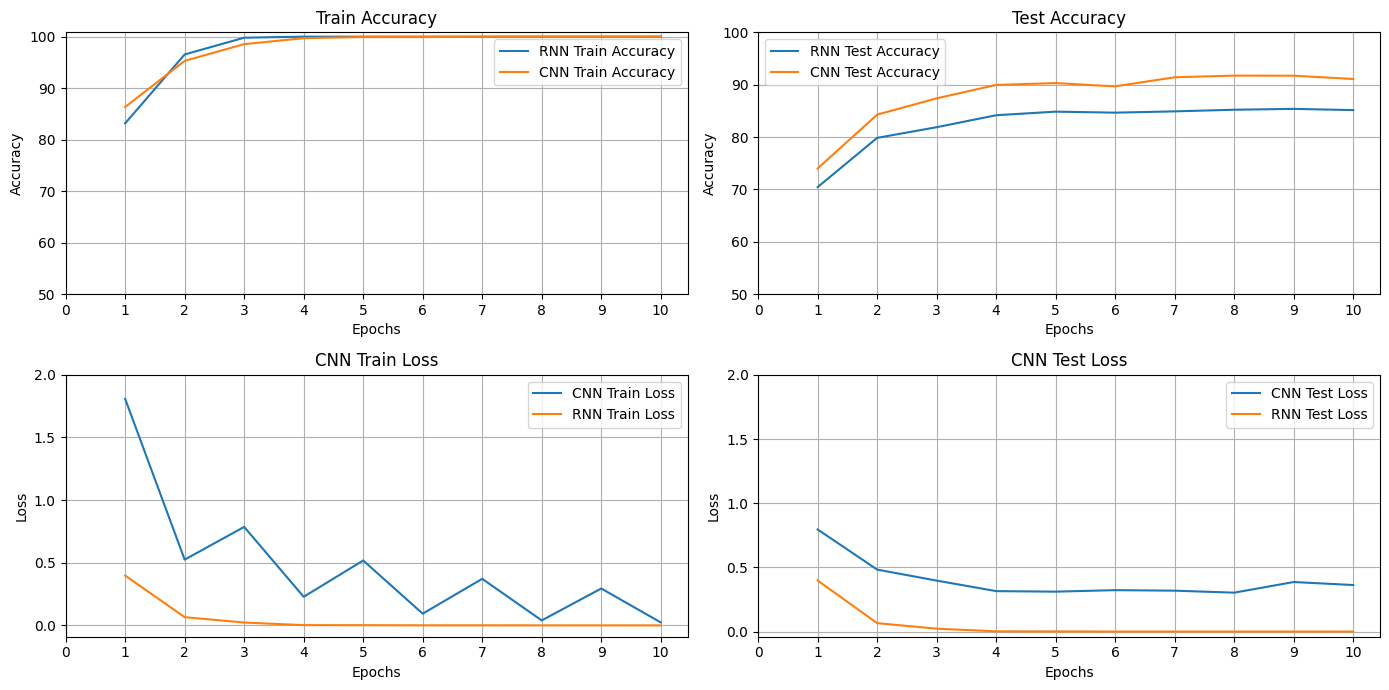

In [24]:
# Visualisation des courbes de précision et de perte pour le RNN et le CNN
plt.figure(figsize=(14, 7))


# Same scale for all plots
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, label='RNN Train Accuracy')
plt.plot(range(1, num_epochs+1), cnn_train_accuracies, label='CNN Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, num_epochs+1))
plt.yticks(range(50, 101, 10))
plt.title('Train Accuracy')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies, label='RNN Test Accuracy')
plt.plot(range(1, num_epochs+1), cnn_test_accuracies, label='CNN Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, num_epochs+1))
plt.yticks(range(50, 101, 10))
plt.title('Test Accuracy')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs+1), cnn_train_losses[:10], label='CNN Train Loss')
plt.plot(range(1, num_epochs+1), train_losses, label='RNN Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, num_epochs+1))
plt.yticks(np.arange(0, 2.5, 0.5))
plt.title('CNN Train Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs+1), cnn_test_losses, label='CNN Test Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='RNN Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, num_epochs+1))
plt.yticks(np.arange(0, 2.5, 0.5))
plt.title('CNN Test Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()